In [3]:
from cooltools.eigdecomp import cis_eig
import cooler
import cooltools

In [4]:
cool = cooler.Cooler('K562_hg19_chr3_50K.cool')
mat = cool.matrix(balance=True)[:]
mat

array([[         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,   0.        , 428.52640111, ...,          nan,
                 nan,          nan],
       [         nan, 428.52640111,   0.        , ...,          nan,
                 nan,          nan],
       ...,
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan]])

In [5]:
#import track file
import pandas as pd
#my_file = open("hg19_GC_chr3_50K.txt", "r")
#content = my_file.read()
#print(content)

#load signal track
signal = pd.read_table("hg19_GC_chr3_50K.txt")
signal.iloc[:,0]
signal.loc[len(signal.index)] = [0.1] 
signal.iloc[:,0]
#signal.append([3960, 2])

0       0.16752
1       0.23058
2       0.17954
3       0.24056
4       0.23108
         ...   
3956    0.23558
3957    0.22148
3958    0.06538
3959    0.00000
3960    0.10000
Name: 0.0, Length: 3961, dtype: float64

In [6]:
#compartment call
comp_call = cooltools.eigdecomp.cis_eig(mat, n_eigs=3, phasing_track=signal.iloc[:,0], ignore_diags=2, clip_percentile=0, sort_metric=None)

comp_call

#write eigenvalues to a bed file
f = open('eigen.bed', 'w')
for t in comp_call:
    line = ' '.join(str(x) for x in t)
    f.write(line + '\n')
f.close()

/Users/cmdb/miniconda3/envs/hic/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


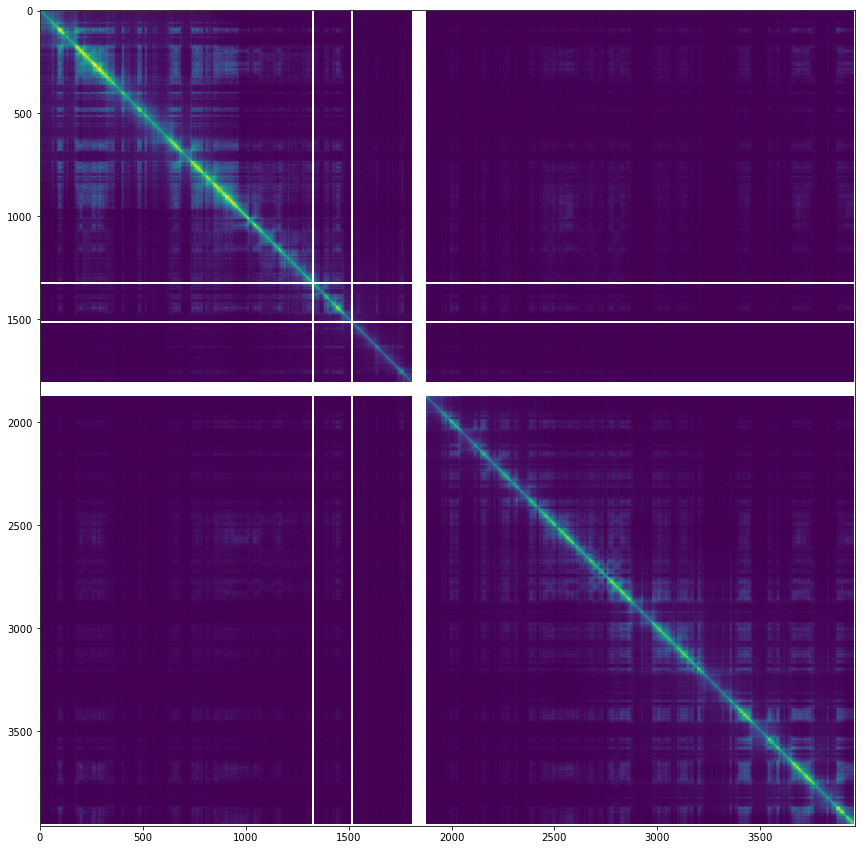

In [7]:
#plot eigenvector with interaction matrix
%matplotlib inline
import matplotlib.pyplot as plt
import numpy

fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(numpy.log10(1 + mat), vmax=3)
fig.show()

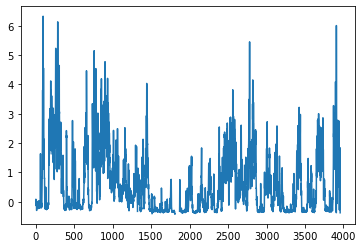

In [8]:
#plot the eigenvector
import numpy as np
plt.plot(np.arange(comp_call[1].shape[1]), comp_call[1][0,:])
plt.show()

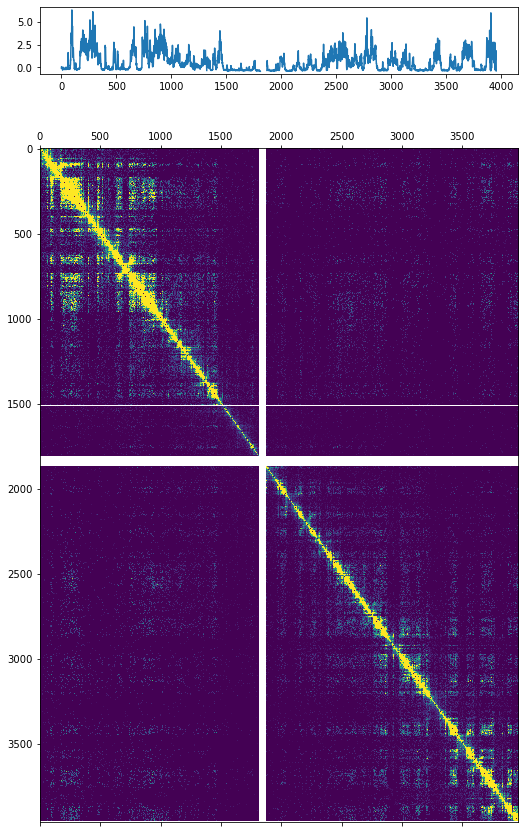

In [9]:
#plot interaction matrix with eigenvector

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as grd
plt.figure(figsize = (15,15))
gs = grd.GridSpec(2,2,
                 height_ratios = [1,10],
                 width_ratios = [6,1], wspace = 1)
ax = plt.subplot(gs[2])
ax = ax.matshow(mat, aspect = "auto",
               vmax = 10)
ax2 = plt.subplot(gs[0])
ax2.plot(np.arange(comp_call[1].shape[1]), comp_call[1][0,:])
plt.show()

In [10]:
#plotting FPKM expression levels 
fpkm = pd.read_table("K562_hg19_FPKM_chr3.bed", delim_whitespace=True, header=None)
fpkm

,0,1,2,3,4,5
0,chr3,238279,451090,CHL1,0.00,+
1,chr3,1134260,1445901,CNTN6,0.00,+
2,chr3,2140497,3099645,CNTN4,0.01,+
3,chr3,3111233,3168297,IL5RA,0.14,-
4,chr3,3168600,3192563,TRNT1,25.28,+
...,...,...,...,...,...,...
1059,chr3,197464050,197514467,FYTTD1,53.14,+
1060,chr3,197518097,197615307,LRCH3,24.13,+
1061,chr3,197615946,197687013,IQCG,3.70,-
1062,chr3,197676858,197683481,RPL35A,1195.67,+


array([[<AxesSubplot:title={'center':'6'}>]], dtype=object)

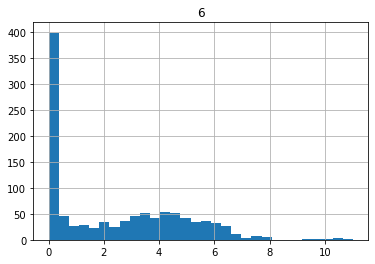

In [15]:
#add column with log2 expression values
import math
fpkm_exp = fpkm.iloc[:,4]
type(fpkm_exp[2])
fpkm[6] = np.log2(fpkm_exp + 1)
fpkm
fpkm.hist(column=6, bins=30)

#based on histogram, cutoff point is 1.7

In [73]:
###Plotting violin plots

#read in compartment and methylation data
comp_methyl = pd.read_table("methyl_comp", delim_whitespace=True, header=None)
comp_methyl

,0,1,2,3,4,5,6,7
0,chr3,238279,451090,CHL1,0.00,+,0,46388.30004
1,chr3,1134260,1445901,CNTN6,0.00,+,0,66197.91633
2,chr3,2140497,3099645,CNTN4,0.01,+,0,260583.33770
3,chr3,3111233,3168297,IL5RA,0.14,-,0,89428.67572
4,chr3,3168600,3192563,TRNT1,25.28,+,0,4045.83578
...,...,...,...,...,...,...,...,...
1059,chr3,197464050,197514467,FYTTD1,53.14,+,0,8602.87112
1060,chr3,197518097,197615307,LRCH3,24.13,+,0,16928.24217
1061,chr3,197615946,197687013,IQCG,3.70,-,0,18817.09862
1062,chr3,197676858,197683481,RPL35A,1195.67,+,0,1151.45649


In [74]:
#add new column to compartment and methylation table, with category for gene A/B and Exp/Not Exp

#Build list for each gene
category = []
for i in range(len(comp_methyl)):
    if comp_methyl.iloc[i,5] == "+":
        if fpkm.iloc[i,6] < 1.7:
            category.append("Comp A Not Expressed")
        if fpkm.iloc[i,6] >= 1.7:
            category.append("Comp A Expressed")
    if comp_methyl.iloc[i,5] == "-":
        if fpkm.iloc[i,6] < 1.7:
            category.append("Comp B Not Expressed")
        if fpkm.iloc[i,6] >= 1.7:
            category.append("Comp A Expressed")

#Add this to methyl comp table 
comp_methyl[9] = category
comp_methyl

,0,1,2,3,4,5,6,7,9
0,chr3,238279,451090,CHL1,0.00,+,0,46388.30004,Comp A Not Expressed
1,chr3,1134260,1445901,CNTN6,0.00,+,0,66197.91633,Comp A Not Expressed
2,chr3,2140497,3099645,CNTN4,0.01,+,0,260583.33770,Comp A Not Expressed
3,chr3,3111233,3168297,IL5RA,0.14,-,0,89428.67572,Comp B Not Expressed
4,chr3,3168600,3192563,TRNT1,25.28,+,0,4045.83578,Comp A Expressed
...,...,...,...,...,...,...,...,...,...
1059,chr3,197464050,197514467,FYTTD1,53.14,+,0,8602.87112,Comp A Expressed
1060,chr3,197518097,197615307,LRCH3,24.13,+,0,16928.24217,Comp A Expressed
1061,chr3,197615946,197687013,IQCG,3.70,-,0,18817.09862,Comp A Expressed
1062,chr3,197676858,197683481,RPL35A,1195.67,+,0,1151.45649,Comp A Expressed


In [75]:
#extract methylation values from comp_methyl, combine into 3 vectors for violin plots
can = []
cae = []
cbn = []
cbe = []
for i in range(len(comp_methyl)):
    if comp_methyl.iloc[i,8] == "Comp A Not Expressed":
        can.append(float(comp_methyl.iloc[i,7]))
    if comp_methyl.iloc[i,8] == "Comp A Expressed":
        cae.append(float(comp_methyl.iloc[i,7]))
    if comp_methyl.iloc[i,8] == "Comp B Not Expressed":
        cbn.append(float(comp_methyl.iloc[i,7]))
    if comp_methyl.iloc[i,8] == "Comp B Expressed":
        cbe.append(float(comp_methyl.iloc[i,7]))

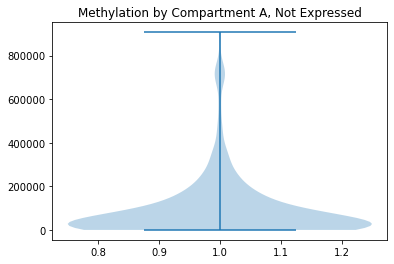

In [84]:
#build violin
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.violinplot([can])
ax.set_title("Methylation by Compartment A, Not Expressed")
plt.show()

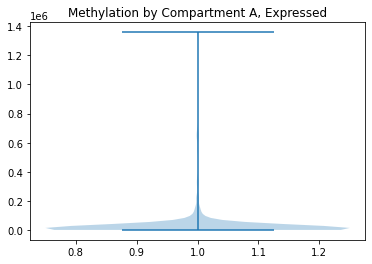

In [85]:
fig, ax = plt.subplots()
ax.violinplot([cae])
ax.set_title("Methylation by Compartment A, Expressed")
plt.show()

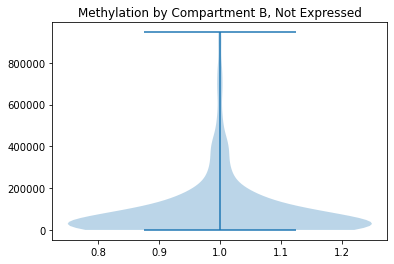

In [86]:
fig, ax = plt.subplots()
ax.violinplot([cbn])
ax.set_title("Methylation by Compartment B, Not Expressed")
plt.show()

In [ ]:
#Note: no genes were found to express in the B category, so these were excluded 